The codebase is largely based off of Fares Sayah's Kaggle post on LSTM for stock prediction: https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm

## Data setup

Get the data, show last few samples:

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.1 MB/s 
     |████████████████████████████████| 112 kB 31.3 MB/s 
     |████████████████████████████████| 110 kB 13.1 MB/s 
     |████████████████████████████████| 128 kB 71.3 MB/s 
     |████████████████████████████████| 62 kB 873 kB/s 
     |████████████████████████████████| 4.0 MB 11.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-12-07,88.339996,89.889999,87.480003,88.459999,88.459999,68086900,AMAZON
2022-12-08,89.239998,90.860001,87.879997,90.349998,90.349998,73305900,AMAZON
2022-12-09,88.900002,90.300003,88.629997,89.089996,89.089996,67316900,AMAZON
2022-12-12,89.209999,90.580002,87.870003,90.550003,90.550003,61999800,AMAZON
2022-12-13,95.230003,96.250000,90.519997,92.489998,92.489998,100212000,AMAZON
2022-12-14,92.500000,93.459999,89.870003,91.580002,91.580002,70298000,AMAZON
2022-12-15,89.889999,89.970001,87.470001,88.449997,88.449997,84802900,AMAZON
2022-12-16,88.269997,89.349998,86.730003,87.860001,87.860001,146044000,AMAZON
2022-12-19,87.510002,87.629997,84.510002,84.919998,84.919998,83363400,AMAZON


Data is structured in date order, with one sample per trading day, and one company after another.

## Data exploration

Describe, get info for sample stock (Amazon)

In [3]:
AMZN.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,73.624853,74.460637,72.685684,73.581370,73.581370,8.024979e+07
std,53.440010,54.094096,52.707429,53.383799,53.383799,4.232201e+07
min,12.187500,12.372000,12.137500,12.259000,12.259000,1.762600e+07
25%,21.780624,21.953001,21.665000,21.818251,21.818251,5.359100e+07
50%,59.056499,59.432249,58.496000,59.035000,59.035000,6.868900e+07
75%,107.947500,110.125498,106.283127,107.755125,107.755125,9.309050e+07
max,187.199997,188.654007,184.839493,186.570496,186.570496,4.771220e+08


In [4]:
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2012-12-20 to 2022-12-20
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2518 non-null   float64
 1   High          2518 non-null   float64
 2   Low           2518 non-null   float64
 3   Close         2518 non-null   float64
 4   Adj Close     2518 non-null   float64
 5   Volume        2518 non-null   int64  
 6   company_name  2518 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 157.4+ KB


Closing prices of all 4 stocks graphed out for visual inspection:

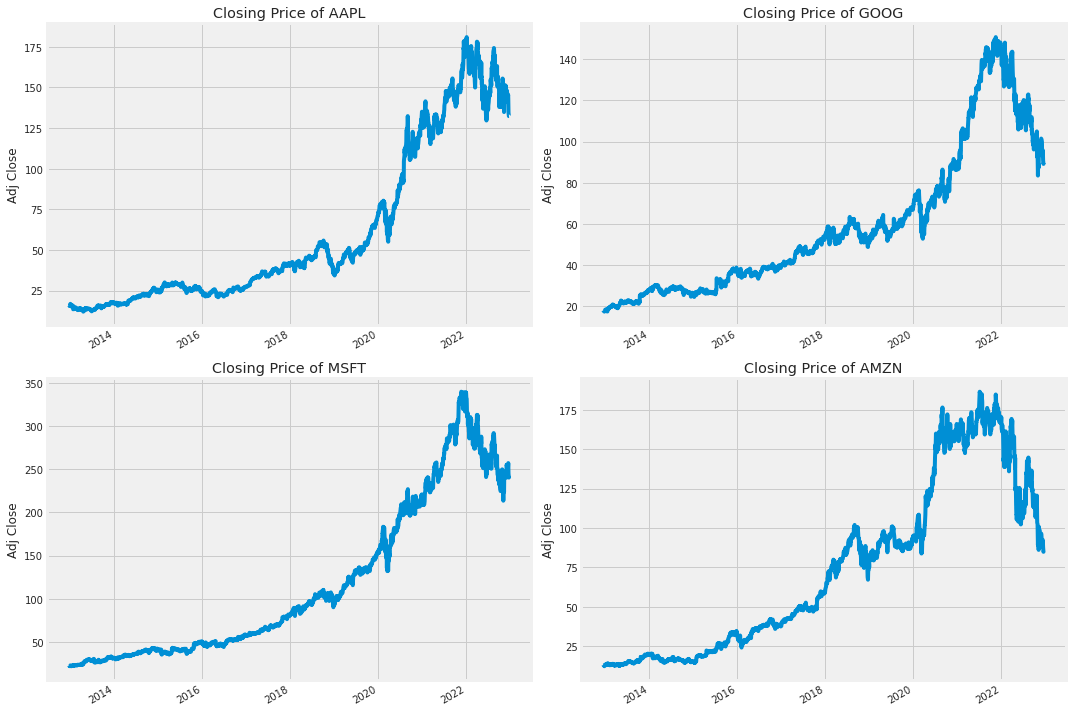

In [5]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

These closing price graphs are what we will apply the Long Short Term Memory(LSTM) model to predict price movements.

## Building the Model

Working with just one market to start (Amazon)

Get just closes, conver to np array

In [6]:
AMZN = AMZN.filter(['Close'])
dataset = AMZN.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

2393

Data scaling, feature space in range 0 to 1:

In [7]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00468127],
       [0.00336753],
       [0.00385517],
       ...,
       [0.43371208],
       [0.4168457 ],
       [0.41882493]])

Get X_train, Y_train (previous samples and current sample)

In [8]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00468127, 0.00336753, 0.00385517, 0.00098961, 0.00089782,
       0.        , 0.00163214, 0.00347941, 0.00381501, 0.0040072 ,
       0.0066777 , 0.00608107, 0.00607246, 0.00578275, 0.00652855,
       0.00790252, 0.00766444, 0.00681252, 0.00725713, 0.00772755,
       0.00717394, 0.00657731, 0.00811192, 0.01113237, 0.00885197,
       0.00435141, 0.00791112, 0.00582864, 0.00568523, 0.00424527,
       0.00622736, 0.0048878 , 0.00431699, 0.00481035, 0.00345072,
       0.00387812, 0.00696741, 0.00690144, 0.00571104, 0.00704773,
       0.00608968, 0.00595486, 0.0058057 , 0.00421372, 0.00406743,
       0.00518325, 0.00547583, 0.00589749, 0.00801152, 0.00872289,
       0.00820657, 0.00823239, 0.00832131, 0.00747513, 0.0083041 ,
       0.00858234, 0.00589749, 0.00477306, 0.00364577, 0.00322125])]
[0.0034708008969812493]

[array([0.00468127, 0.00336753, 0.00385517, 0.00098961, 0.00089782,
       0.        , 0.00163214, 0.00347941, 0.00381501, 0.0040072 ,
       0.0066777 , 0.00608107, 0.

Model Configuration, training

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2333/2333 [==============================] - 31s 9ms/step - loss: 0.0017


## Testing

Build test dataset, make predictions

In [10]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4/4 [==============================] - 1s 5ms/step


6.320519337511324

Visual inspection of model

<ipython-input-11-4f2f3bb78c72>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


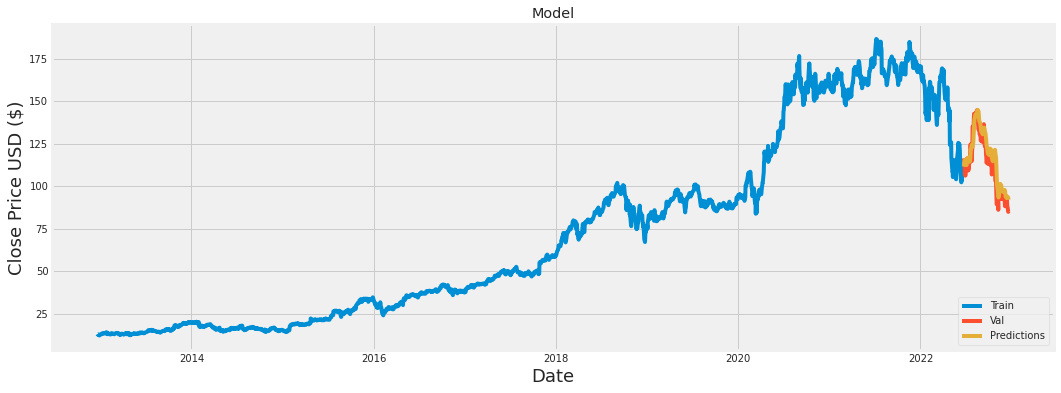

In [11]:
# Plot the data
train = AMZN[:training_data_len]
valid = AMZN[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [12]:
valid

,Close,Predictions
Date,,
2022-06-24,116.459999,111.487740
2022-06-27,113.220001,113.863403
2022-06-28,107.400002,115.434532
2022-06-29,108.919998,115.200630
2022-06-30,106.209999,114.501564
...,...,...
2022-12-14,91.580002,93.497612
2022-12-15,88.449997,93.990028
2022-12-16,87.860001,93.807808


## Making some tweaks

Since most the work until now heavily follows the cited Kaggle post, the blocks below are things I tried to alter performance or use case.

### Change 1

Tweaking model hyper paramters and comparing root mean squared error (RMSE).

In [26]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True,  input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(50))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
2333/2333 [==============================] - 24s 9ms/step - loss: 0.0021
Epoch 2/5
2333/2333 [==============================] - 20s 9ms/step - loss: 9.6556e-04
Epoch 3/5
2333/2333 [==============================] - 20s 9ms/step - loss: 9.6905e-04
Epoch 4/5
2333/2333 [==============================] - 20s 9ms/step - loss: 4.1060e-04
Epoch 5/5
2333/2333 [==============================] - 20s 9ms/step - loss: 4.6042e-04


In [27]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4/4 [==============================] - 1s 6ms/step


4.658552564560795

Here I added an extra dense layer with 50 nodes immediately after the LSTM layers, and I had the model train for 5 epochs rather than 1. As a result, RMSE on the valid set has dropped from 6.32 to 4.66.

Visual inspection of model's predictions of valid set:

<ipython-input-28-4f2f3bb78c72>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


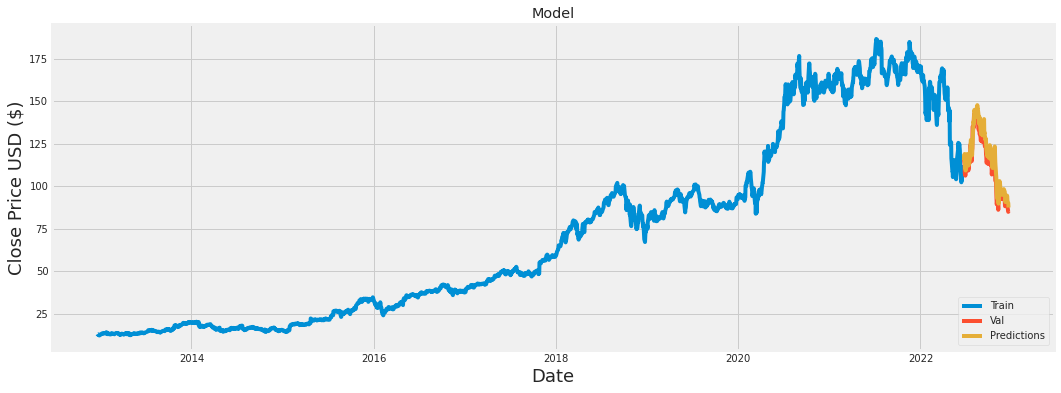

In [28]:
# Plot the data
train = AMZN[:training_data_len]
valid = AMZN[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

The predictions and valid line overlap even more tightly before, showing the new architecture/extra training time clearly improved model accuracy.

### Change 2

Next, I wanted to see if this approach to price prediction could be applied to alternate time frames. Up until now we've always had a data resolution of 1 trading day (1 data point for each day, that is the closing price of that day). If the model can have comparable performance on a finer resolution, such as a datapoint every 1 hour or 15 minutes, the approach might be suitable for daytrading.

In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year-1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end, interval='60m')
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Datetime,,,,,,,
2021-12-20 09:30:00,168.279999,169.930099,167.460007,167.945007,167.945007,26790703,APPLE
2021-12-20 10:30:00,167.940002,169.148407,167.730103,168.729996,168.729996,14012592,APPLE
2021-12-20 11:30:00,168.729996,170.580002,168.309998,170.104996,170.104996,12464735,APPLE
2021-12-20 12:30:00,170.100006,170.134995,168.820007,169.421600,169.421600,9234913,APPLE
2021-12-20 13:30:00,169.421005,170.289993,169.184998,169.598404,169.598404,9490330,APPLE
2021-12-20 14:30:00,169.589996,170.429993,169.360001,169.779999,169.779999,9268551,APPLE
2021-12-20 15:30:00,169.770004,170.190002,169.089996,169.910004,169.910004,10243967,APPLE
2021-12-21 09:30:00,171.554993,172.279999,169.350006,169.572906,169.572906,21794239,APPLE
2021-12-21 10:30:00,169.585007,170.699997,169.119995,170.299103,170.299103,10926527,APPLE


Closing graphs on new resolution

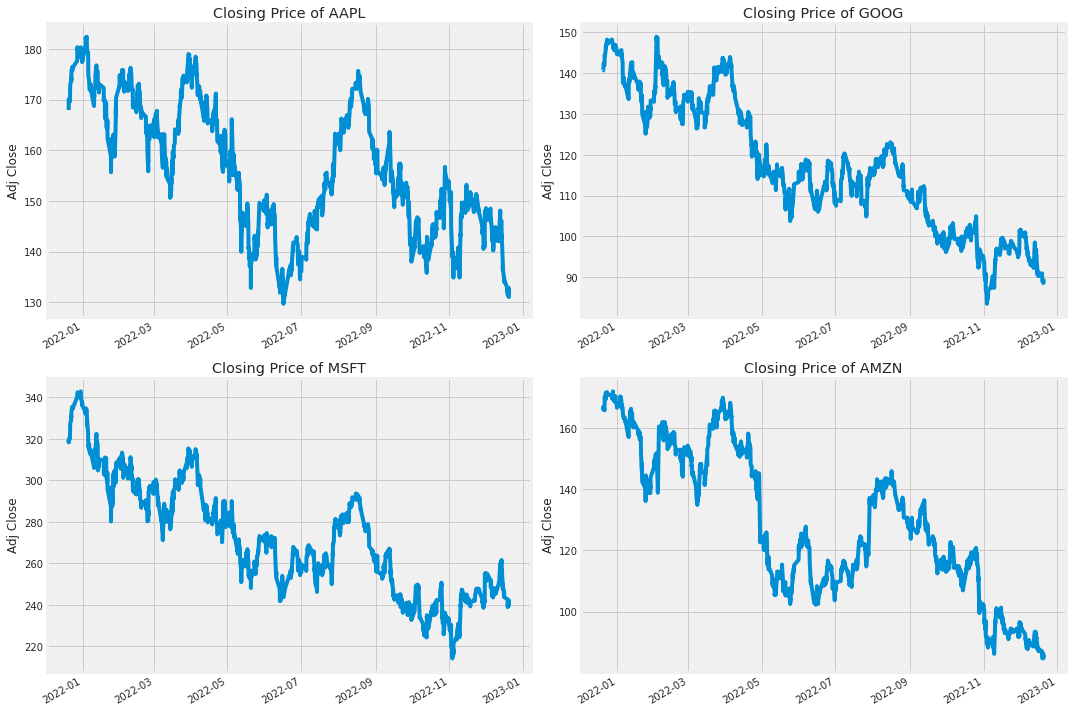

In [34]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

First intuition is that, while there's still trend, the graphs look slightly noisier on this higher resolution, so I expect this will hurt model performance.

In [35]:
AMZN = AMZN.filter(['Close'])
dataset = AMZN.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

1680

In [36]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.94370936],
       [0.93191839],
       [0.93461733],
       ...,
       [0.00814742],
       [0.00717646],
       [0.00608997]])

In [37]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.94370936, 0.93191839, 0.93461733, 0.93666448, 0.9402569 ,
       0.9397695 , 0.94283438, 0.92899416, 0.94391528, 0.96104287,
       0.96950458, 0.97737855, 0.97561742, 0.98044919, 0.97449655,
       0.99523681, 0.99252059, 0.97909798, 0.9709626 , 0.97936288,
       0.98807745, 0.98414893, 0.99364704, 0.99097097, 0.99670913,
       0.98970509, 0.98954698, 0.98732829, 0.98758865, 0.9869332 ,
       0.97882522, 0.9783106 , 0.97331287, 0.97276962, 0.97242654,
       0.98588459, 1.        , 0.98910391, 0.98617601, 0.98207333,
       0.98491519, 0.98358283, 0.96633936, 0.96748029, 0.96256563,
       0.96244818, 0.96838965, 0.96734295, 0.96630795, 0.9817416 ,
       0.97940563, 0.97540871, 0.97898821, 0.97478816, 0.97039073,
       0.96052668, 0.95495691, 0.95537451, 0.94899311, 0.94989078])]
[0.9464770534423239]

[array([0.94370936, 0.93191839, 0.93461733, 0.93666448, 0.9402569 ,
       0.9397695 , 0.94283438, 0.92899416, 0.94391528, 0.96104287,
       0.96950458, 0.97737855, 0.975

Train on new data resolution, using the apparent improvements from my first change to model configuration.

In [38]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True,  input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(50))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1620/1620 [==============================] - 18s 9ms/step - loss: 0.0029
Epoch 2/5
1620/1620 [==============================] - 17s 10ms/step - loss: 0.0011
Epoch 3/5
1620/1620 [==============================] - 15s 9ms/step - loss: 8.8982e-04
Epoch 4/5
1620/1620 [==============================] - 15s 9ms/step - loss: 7.9150e-04
Epoch 5/5
1620/1620 [==============================] - 14s 9ms/step - loss: 7.1829e-04


Test, get RMSE:

In [39]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3/3 [==============================] - 1s 6ms/step


1.6070204164008401

Visual comparison:

<ipython-input-41-b24206e9fb77>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


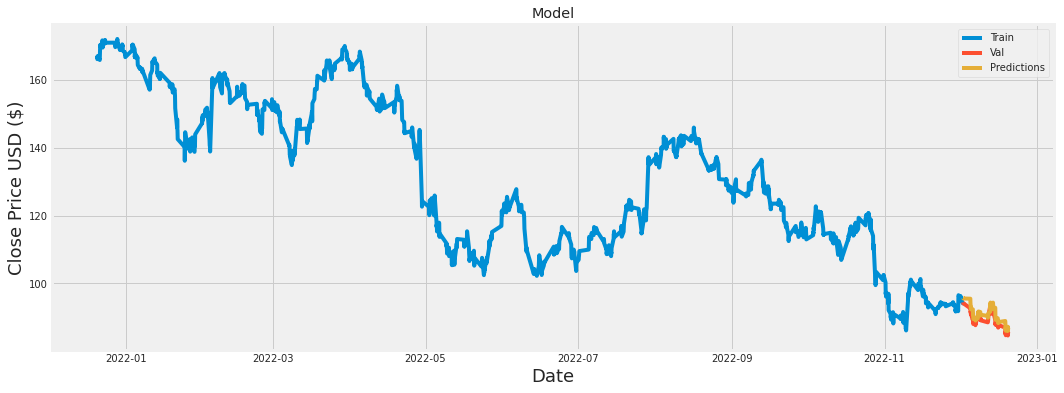

In [41]:
# Plot the data
train = AMZN[:training_data_len]
valid = AMZN[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [42]:
valid

,Close,Predictions
Datetime,,
2022-12-02 12:30:00,94.434998,95.816162
2022-12-02 13:30:00,94.195000,95.804161
2022-12-02 14:30:00,94.195000,95.596809
2022-12-02 15:30:00,94.120003,95.569344
2022-12-05 09:30:00,92.684998,95.497490
...,...,...
2022-12-20 11:30:00,85.404999,86.069008
2022-12-20 12:30:00,85.589897,86.537277
2022-12-20 13:30:00,85.369904,86.742760


RMSE is significantly lower with this resolution, probably as the volatility for the price is lower with less time between datapoints. Strangely, the model was pretty consistently guessing above the true value of the stock price, but its guesses were somewhat accurate in terms of direction (will the price be higher or lower than previously), so it may still have value for trading purposes.

## Conclusion

Long Term Short Memory (LTSM) models are effective at predicting time series data, and therefore are directly applicable to stock market price graphs. I experimented with a few model configurations to get better valid acc, and I looked into model performance at different data resolutions. I found that the approach to predicition appears relatively agnostic to time interval between datapoints, so this tool could be useful for different styles of stock trading (intraday, day and long term).